In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 0. Một số thông tin về tập dữ liệu BraTS2023

BraTS (Brain Tumor Segmentation) là một tập dữ liệu y khoa được sử dụng phổ biến trong nghiên cứu về chẩn đoán và phân đoạn khối u não. Dữ liệu này chứa hình ảnh chụp cộng hưởng từ (MRI) với nhiều chế độ khác nhau.

### *1.1 Dưới đây là các thuật ngữ liên quan đến các loại ảnh MRI có trong BraTS2023-GLI*:

**1. Native (T1)**

* Đây là ảnh chụp MRI theo chuỗi T1-weighted (T1W).
* T1W giúp hiển thị rõ các cấu trúc giải phẫu của não, với dịch não tủy (CSF) có màu tối, chất xám có màu xám và chất trắng có màu sáng.
* Được sử dụng để phân biệt mô não bình thường và bất thường.

**2. Post-contrast T1-weighted (T1CE)**
* Đây là ảnh T1-weighted có sử dụng chất tương phản (Contrast-Enhanced, CE), thường là Gadolinium.
* Chất tương phản giúp tăng độ sáng của các vùng mô bất thường, đặc biệt là các khối u hoặc vùng có hàng rào máu não bị tổn thương.
* Thường được sử dụng để xác định vị trí và kích thước khối u.

**3. T2-weighted (T2)**
* Ảnh T2-weighted (T2W) làm nổi bật sự khác biệt giữa các mô bằng cách tăng cường độ sáng của dịch não tủy (CSF), trong khi chất trắng xuất hiện tối hơn chất xám.
* Rất hữu ích để phát hiện các bất thường như phù nề xung quanh khối u, tổn thương hoặc viêm.

**4. T2 Fluid Attenuated Inversion Recovery (FLAIR)**
* Đây là một biến thể của ảnh T2, trong đó tín hiệu từ dịch não tủy (CSF) được triệt tiêu, giúp làm rõ các tổn thương nằm gần hoặc bên trong não thất.
* Được sử dụng phổ biến để phát hiện phù nề, tổn thương viêm nhiễm hoặc bệnh lý não trắng (ví dụ: đa xơ cứng - MS).

### *1.2 Cấu trúc dataset*
* Dữ liệu chứa trong 2 tập `brats2023-part-1 (625 sample)` và `/kaggle/input/brats2023-part-2zip (626 sample)` có cấu trúc:
```
brats2023-part-
├── BraTS-GLI-00000-000
├── BraTS-GLI-00002-000
├── BraTS-GLI-00003-000
├── BraTS-GLI-00005-000
...
```

* Mỗi sample có cấu trúc:

```
brats2023-part-1/BraTS-GLI-00000-000
├── BraTS-GLI-00000-000-seg.nii
├── BraTS-GLI-00000-000-t1c.nii
├── BraTS-GLI-00000-000-t1n.nii
├── BraTS-GLI-00000-000-t2f.nii
└── BraTS-GLI-00000-000-t2w.nii
```

Mỗi file ```.nii``` là 1 ảnh 3D, 4 file tương ứng với 4 ảnh được giải thích phía trên. Với file```seg.nii``` chứa ảnh được segment từ 4 ảnh trên, gồm 4 pixel tương ứng với 4 classes:
| **Class Index** | **Description**                         | **Viridis Color (for visualization)** |
|-----------------|-----------------------------------------|--------------------------------------|
| 0               | Background                              | Dark purple (or black)               |
| 1               | Necrotic and Non-enhancing Tumor Core   | Blue or dark green                   |
| 2               | Peritumoral Edema/Invaded Tissue        | Light green or teal                  |
| 3               | GD-Enhancing Tumor                      | Yellow                               |

# 1. Cài và import các thư viện cần thiết

In [2]:
!pip install nibabel -q
!pip install scikit-learn -q
!pip install tqdm -q
!pip install split-folders -q
!pip install torchinfo -q
!pip install segmentation-models-pytorch-3d -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 32.5 MB/s eta 0:00:00


In [3]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torch.cuda import amp

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc

import segmentation_models_pytorch_3d as smp

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter


def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

### 2.1 Cấu hình các tham số mặc định

In [4]:
TRAIN_DATASET_PATH = '/kaggle/input/brats2023-part-1/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats2023-part-2zip'
OUTPUT_DIR = "./kaggle/working"

IMAGE_OUTPUT_DIR = "BraTS2023_Preprocessed/input_data_3channels/images"
MASK_OUTPUT_DIR = "BraTS2023_Preprocessed/input_data_3channels/mask"


# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 77 # sử dụng 1 lát cắt ở giữa để hiện thị

IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155
IMG_CHANNELS = 3

# 2. Trực quan hóa dataset dataset

### 2.1 Đọc ảnh và mask của 1 sample

In [5]:
# sử dụng thư viện nibabel để đọc file có đuôi .nii

def load_nii(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data

test_image_flair= load_nii(TRAIN_DATASET_PATH + 'BraTS-GLI-00012-000/BraTS-GLI-00012-000-t2f.nii')
test_image_t1= load_nii(TRAIN_DATASET_PATH + 'BraTS-GLI-00012-000/BraTS-GLI-00012-000-t1n.nii')
test_image_t1ce= load_nii(TRAIN_DATASET_PATH + 'BraTS-GLI-00012-000/BraTS-GLI-00012-000-t1c.nii')
test_image_t2= load_nii(TRAIN_DATASET_PATH + 'BraTS-GLI-00012-000/BraTS-GLI-00012-000-t2w.nii')
test_mask= load_nii(TRAIN_DATASET_PATH + 'BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii')

print(test_mask.shape)

(240, 240, 155)


### 2.2 Plot ảnh 3D theo trục từ trên xuống (Axial - Z)

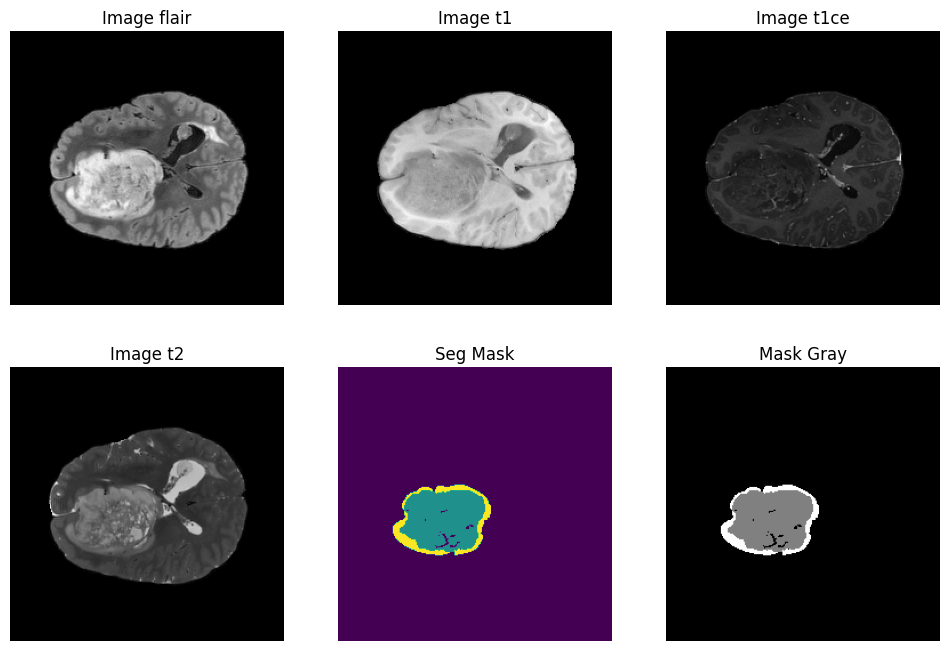

In [6]:
# plot ảnh 3D theo trục từ trên xuống (Axial - Z)

# Hiển thị ảnh 2D đơn giản là hiển thị một mảng 2 chiều.
# Hiển thị ảnh 3D đòi hỏi phải xử lý thêm chiều thứ ba bằng cách chọn một lát cắt để xem hoặc sử dụng các kỹ thuật trực quan hóa 3D để khám phá toàn bộ thể tích.

def visulize_brain(image_flair, image_t1, image_t1ce, image_t2, mask):
    plt.figure(figsize=(12, 8))

    plt.subplot(231)
    plt.imshow(image_flair, cmap='gray')
    plt.title('Image flair')
    plt.axis('off')  # Remove axis

    plt.subplot(232)
    plt.imshow(image_t1, cmap='gray')
    plt.title("Image t1")
    plt.axis('off')  # Remove axis

    plt.subplot(233)
    plt.imshow(image_t1ce, cmap='gray')
    plt.title("Image t1ce")
    plt.axis('off')  # Remove axis

    plt.subplot(234)
    plt.imshow(image_t2, cmap='gray')
    plt.title("Image t2")
    plt.axis('off')  # Remove axis

    plt.subplot(235)
    plt.imshow(mask)
    plt.title("Seg Mask")
    plt.axis('off')  # Remove axis

    plt.subplot(236)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask Gray')
    plt.axis('off')  # Remove axis

    # Lưu ảnh
    plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
    plt.show()


visulize_brain(test_image_flair[:, :, VOLUME_SLICES],
               test_image_t1[:, :, VOLUME_SLICES],
               test_image_t1ce[:, :, VOLUME_SLICES],
               test_image_t2[:, :, VOLUME_SLICES],
               test_mask[:, :, VOLUME_SLICES])


### 2.3 Plot ảnh 3D theo chiều từ trái qua phải (Sagittal - X)

120


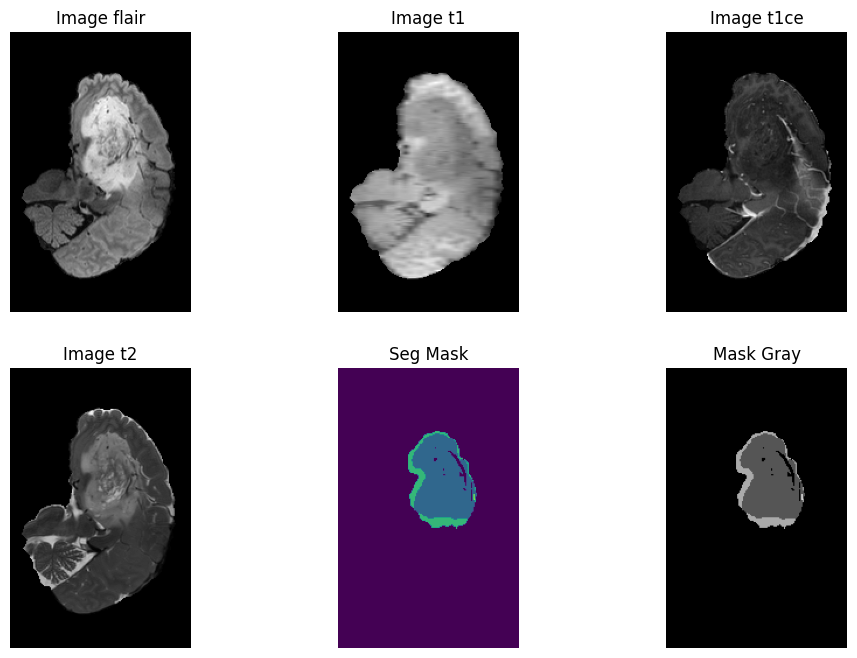

In [7]:
# plot ảnh 3D theo trục từ trên xuống (Sagittal - X)

# Hiển thị ảnh 2D đơn giản là hiển thị một mảng 2 chiều.
# Hiển thị ảnh 3D đòi hỏi phải xử lý thêm chiều thứ ba bằng cách chọn một lát cắt để xem hoặc sử dụng các kỹ thuật trực quan hóa 3D để khám phá toàn bộ thể tích.

VOLUME_SLICES = test_image_flair.shape[0] // 2
print(VOLUME_SLICES)


visulize_brain(test_image_flair[VOLUME_SLICES, :, :],
               test_image_t1[VOLUME_SLICES, :, :],
               test_image_t1ce[VOLUME_SLICES, :, :],
               test_image_t2[VOLUME_SLICES, :, :],
               test_mask[VOLUME_SLICES, :, :]
              )


### 2.4 Plot ảnh 3D theo chiều từ trước ra sau (Coronal - Y)

120


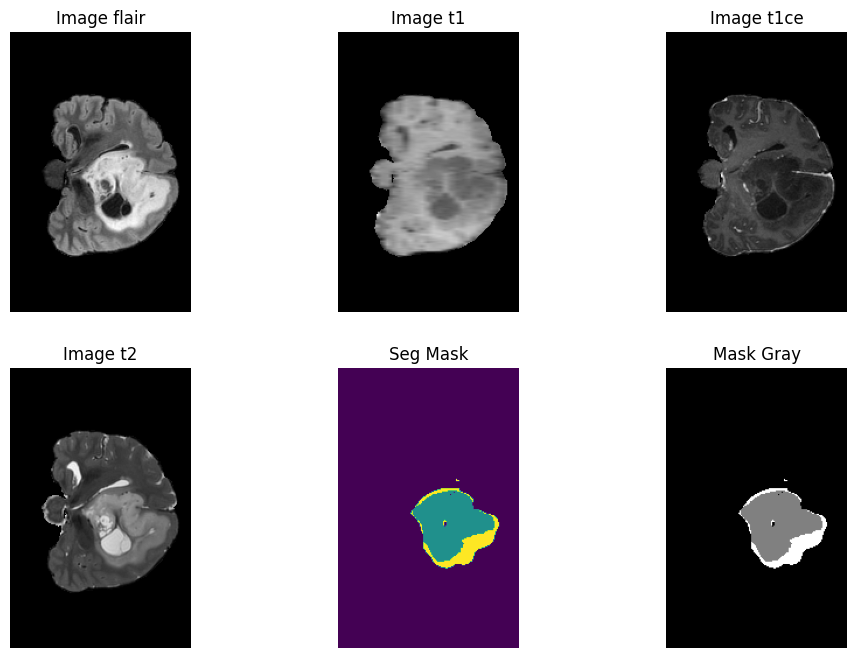

In [8]:
# plot ảnh 3D theo trục từ trên xuống (Coronal - Y)

# Hiển thị ảnh 2D đơn giản là hiển thị một mảng 2 chiều.
# Hiển thị ảnh 3D đòi hỏi phải xử lý thêm chiều thứ ba bằng cách chọn một lát cắt để xem hoặc sử dụng các kỹ thuật trực quan hóa 3D để khám phá toàn bộ thể tích.


VOLUME_SLICES = test_image_flair.shape[1] // 2
print(VOLUME_SLICES)

visulize_brain(test_image_flair[:, VOLUME_SLICES, :],
               test_image_t1[:, VOLUME_SLICES, :],
               test_image_t1ce[:, VOLUME_SLICES, :],
               test_image_t2[:, VOLUME_SLICES, :],
               test_mask[:, VOLUME_SLICES, :]
              )


# 3. Xử lý dữ liệu

### 3.1 Kiểm tra số lượng label và xem dữ liệu có mất cân bằng hay không

Dễ thấy trong 1 ảnh label, background sẽ có số lượng nhiều hơn các class khác. Ngoài ra các class khác cũng mất cân bằng với nhau => ta sẽ phải sử dụng các hàm loss cho dữ liệu mất cân bằng

In [9]:
values, counts = np.unique(test_mask, return_counts=True)

print("Số lượng classes ", np.unique(test_mask))
print("Số lượng mỗi class có trong mask: ", counts)

Số lượng classes  [0. 1. 2. 3.]
Số lượng mỗi class có trong mask:  [8664191  171723   91862     224]


In [13]:
import os
import numpy as np
import nibabel as nib  # Nếu dữ liệu là .nii hoặc .nii.gz


def foreground_ratio(mask_path):
    mask = nib.load(mask_path).get_fdata()  # Đọc ảnh 3D
    return np.sum(mask > 0) / mask.size  # Tỷ lệ pixel foreground

mask_list = sorted(glob.glob(f"{TRAIN_DATASET_PATH}/*/*seg.nii"))

# Tạo danh sách tỷ lệ foreground theo từng ảnh 3D
image_foreground = {path_mask: foreground_ratio(path_mask) for path_mask in mask_list}

# Sắp xếp theo tỷ lệ foreground giảm dần
sorted_images = sorted(image_foreground.items(), key=lambda x: x[1], reverse=True)
sorted_images

[('/kaggle/input/brats2023-part-1/BraTS-GLI-00012-000/BraTS-GLI-00012-000-seg.nii',
  0.029548499103942652),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00686-000/BraTS-GLI-00686-000-seg.nii',
  0.028573924731182795),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00605-000/BraTS-GLI-00605-000-seg.nii',
  0.028258736559139786),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00558-001/BraTS-GLI-00558-001-seg.nii',
  0.02755779569892473),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00657-000/BraTS-GLI-00657-000-seg.nii',
  0.027496639784946236),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00095-001/BraTS-GLI-00095-001-seg.nii',
  0.027143593189964156),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00060-000/BraTS-GLI-00060-000-seg.nii',
  0.026923499103942653),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00095-000/BraTS-GLI-00095-000-seg.nii',
  0.02648163082437276),
 ('/kaggle/input/brats2023-part-1/BraTS-GLI-00402-000/BraTS-GLI-00402-000-seg.nii',
  0.025917226702508962),
 ('/kaggle/input/brat

### 3.2 Scale dữ liệu về khoảng [0, 1]
Ta sử dụng hàm MinMaxScaler của sklearn.preprocessing, tuy nhiên hàm này chỉ nhận dữ liệu 2D. Vì vậy ra scale ảnh 3D về 2D, scale ảnh 2D và chuyển lại về 3D

In [14]:
scaler = MinMaxScaler()

# 1.reshape ảnh về 2D
test_image_flair_flat=test_image_flair.reshape(-1, test_image_flair.shape[-1])
test_image_t1_flat=test_image_t1.reshape(-1, test_image_t1.shape[-1])
test_image_t1ce_flat=test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])
test_image_t2_flat=test_image_t2.reshape(-1, test_image_t2.shape[-1])

# 2. scale ảnh
test_image_flair_scaled = scaler.fit_transform(test_image_flair_flat)
test_image_t1_scaled = scaler.fit_transform(test_image_t1_flat)
test_image_t1ce_scaled = scaler.fit_transform(test_image_t1ce_flat)
test_image_t2_scaled = scaler.fit_transform(test_image_t2_flat)

# 3. reshape lại ảnh 3D
test_image_flair_scaled = test_image_flair_scaled.reshape(test_image_flair.shape)
test_image_t1_scaled = test_image_t1_scaled.reshape(test_image_t1.shape)
test_image_t1ce_scaled = test_image_t1ce_scaled.reshape(test_image_t1ce.shape)
test_image_t2_scaled = test_image_t2_scaled.reshape(test_image_t2.shape)

print("Giá trị lớn nhất của 1 pixel trong ảnh: ", test_image_flair_scaled.max())
print("test_image_flair_scaled shape: ", test_image_flair_scaled.shape)

Giá trị lớn nhất của 1 pixel trong ảnh:  1.0
test_image_flair_scaled shape:  (240, 240, 155)


### 5.3 Combine 3 loại ảnh Flair, TCE, T2 thành 1 ảnh có nhiều chiều. Sau đó lấy các slice quan trọng từ ảnh đó

* Dựa trên các quan sát và đề xuất cộng đồng, thay vì xử lý (và huấn luyện) từng loại ảnh (modalities) riêng lẻ, chúng ta sẽ kết hợp tất cả các loại ảnh đó thành một đầu vào duy nhất cho mô hình

* Mô hình sẽ có một "biểu diễn tổng hợp" (combined representation) chứa đầy đủ các thông tin từ tất cả các modalty về toàn bộ bộ quét não. Điều này giúp mô hình học được mối liên hệ giữa các loại ảnh khác nhau, từ đó có thể cải thiện hiệu quả trong việc nhận diện, phân đoạn hay chẩn đoán các đặc trưng của não.

* Ba loại ảnh được cho là giàu thông tin hơn là Flair, TCE, T2 -> ta sẽ lấy 3 hình ảnh này và combine chúng

In [15]:
combined_x = np.stack(arrays=[test_image_flair_scaled,
                              test_image_t1ce_scaled,
                              test_image_t2_scaled], axis=3)
combined_x.shape

(240, 240, 155, 3)

* Huấn luyện với kích thước ảnh gốc là tốn bộ nhớ:

Nếu sử dụng toàn bộ ảnh gốc (với đầy đủ kích thước ban đầu) để huấn luyện mô hình, điều này sẽ yêu cầu một lượng bộ nhớ rất lớn và có thể không cần thiết vì không phải toàn bộ phần ảnh đều chứa thông tin quan trọng cho việc phân tích (chẳng hạn như các vùng ngoài não không chứa thông tin về bệnh lý).

* Tập trung vào ROI (Region of Interest – Vùng quan tâm):

Thay vì huấn luyện trên toàn bộ ảnh, một cách tiếp cận tối ưu là chỉ lấy phần ảnh chứa vùng não (vùng có nhiều thông tin hữu ích về bệnh lý) để giảm thiểu dữ liệu không cần thiết. ROI ở đây đề cập đến phần ảnh quanh vùng não, nơi mà hầu hết các đặc điểm cần thiết để chẩn đoán hoặc phân đoạn nằm.

* Việc cắt xén (slicing và cropping) từ 56 đến 184:

Qua quá trình thử nghiệm (trial and error), đã xác định rằng việc lấy phần ảnh (theo chiều thứ 3 – thường là trục z, chứa các lát cắt của ảnh 3D) từ chỉ số 56 đến 184 tạo thành một ROI hợp lý. Nghĩa là, trong số các lát cắt của ảnh, các lát từ thứ 56 đến 184 chứa phần não cần thiết cho bài toán, và các lát cắt bên ngoài khoảng này có thể không quan trọng hoặc chứa nhiều thông tin dư thừa.

In [16]:
def caculate_size(img):
    size_in_bytes = img.nbytes
    size_in_mb = size_in_bytes / (1024 ** 2)  # Convert from bytes to megabytes
    return size_in_mb

size_in_mb = caculate_size(combined_x)
print(f"Dung lượng của một ảnh 3D: {size_in_mb:.2f} MB")

size_in_mb = caculate_size(test_mask)
print(f"Dung lượng của mask 3D: {size_in_mb:.2f} MB")

Dung lượng của một ảnh 3D: 204.35 MB
Dung lượng của mask 3D: 68.12 MB


In [17]:
combined_x_cropped = combined_x[56:184, 56:184, 13:141]
print("Shape after cropping: ", combined_x_cropped.shape)

test_mask_c = test_mask[56:184,56:184, 13:141]
print("Mask shape after cropping: ", test_mask_c.shape)

Shape after cropping:  (128, 128, 128, 3)
Mask shape after cropping:  (128, 128, 128)


In [18]:
# tính dung lượng của ảnh 3D sau khi được slice và crop

size_in_mb = caculate_size(combined_x_cropped)
print(f"Dung lượng của một ảnh 3D sau khi crop: {size_in_mb:.2f} MB")

size_in_mb = caculate_size(test_mask_c)
print(f"Dung lượng của mask 3D sau khi crop: {size_in_mb:.2f} MB")

Dung lượng của một ảnh 3D sau khi crop: 48.00 MB
Dung lượng của mask 3D sau khi crop: 16.00 MB


#### Plot các ảnh từ ảnh được combine và crop

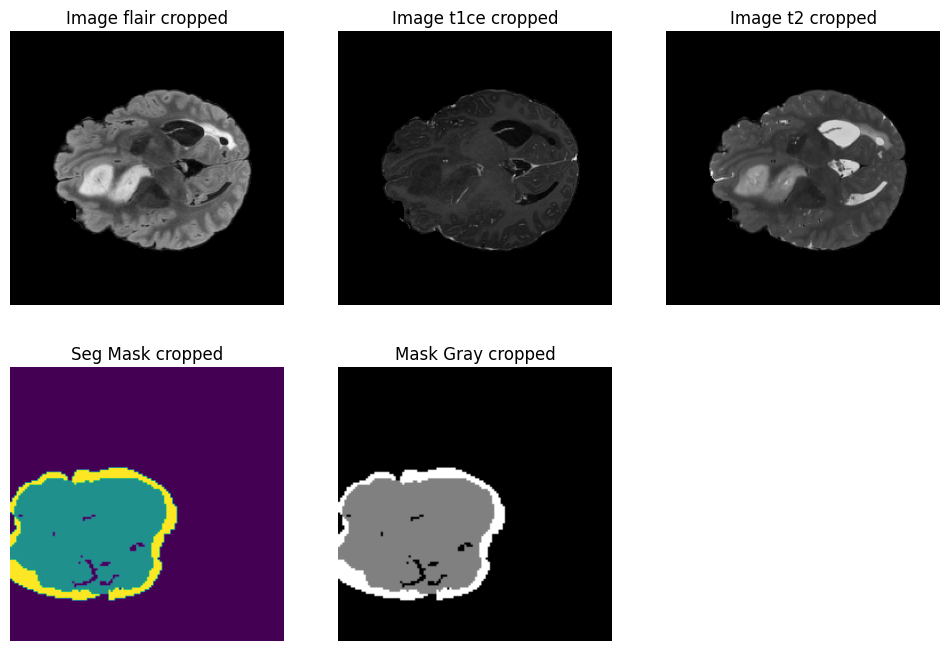

In [19]:
import matplotlib.pyplot as plt
import random

n_slice = combined_x_cropped.shape[-2]//2 # sử dụng 1 lát cắt random để hiện thị

plt.figure(figsize=(12, 8))

# Display 'Image flair'
plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair cropped')
plt.axis('off')  # Remove axis

# Display 'Image t1ce'
plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title("Image t1ce cropped")
plt.axis('off')  # Remove axis

# Display 'Image t2'
plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title("Image t2 cropped")
plt.axis('off')  # Remove axis

# Display segmentation mask without gray scale
plt.subplot(234)
plt.imshow(test_mask_c[:, :, n_slice])
plt.title("Seg Mask cropped")
plt.axis('off')  # Remove axis

# Display segmentation mask in gray scale
plt.subplot(235)
plt.imshow(test_mask_c[:, :, n_slice], cmap='gray')
plt.title('Mask Gray cropped')
plt.axis('off')  # Remove axis

plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()



### 5.4 Convert các giá trị của mask thành dạng one-hot
```
[0] -> [1, 0, 0, 0]
[1] -> [0, 1, 0, 0]
[2] -> [0, 0, 1, 0]
[3] -> [0, 0, 0, 1]
```

In [20]:
test = torch.randint(0, 3, (3, 3, 3))
print(test)
test_one_hot  = F.one_hot(torch.tensor(test, dtype = torch.long), num_classes = 4)
test_one_hot

tensor([[[0, 1, 2],
         [0, 0, 0],
         [0, 2, 0]],

        [[2, 1, 2],
         [1, 2, 2],
         [0, 1, 0]],

        [[0, 1, 2],
         [1, 1, 1],
         [2, 1, 0]]])


<ipython-input-20-da1b4ae72172>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_one_hot  = F.one_hot(torch.tensor(test, dtype = torch.long), num_classes = 4)


tensor([[[[1, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, 1, 0]],

         [[1, 0, 0, 0],
          [1, 0, 0, 0],
          [1, 0, 0, 0]],

         [[1, 0, 0, 0],
          [0, 0, 1, 0],
          [1, 0, 0, 0]]],


        [[[0, 0, 1, 0],
          [0, 1, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [0, 0, 1, 0],
          [0, 0, 1, 0]],

         [[1, 0, 0, 0],
          [0, 1, 0, 0],
          [1, 0, 0, 0]]],


        [[[1, 0, 0, 0],
          [0, 1, 0, 0],
          [0, 0, 1, 0]],

         [[0, 1, 0, 0],
          [0, 1, 0, 0],
          [0, 1, 0, 0]],

         [[0, 0, 1, 0],
          [0, 1, 0, 0],
          [1, 0, 0, 0]]]])

In [21]:
test_mask_c.shape

(128, 128, 128)

In [22]:
test_mask_one_hot  = F.one_hot(torch.tensor(test_mask_c, dtype = torch.long), num_classes = 4)
# 0, 1, 2, 3  -> dtype = torch.long as F.one_hot expects in int64
# If the tensor is not of integer type (e.g., float32 or uint8),
# it will raise an error because one-hot encoding cannot work with non-integer values.

In [23]:
test_mask_one_hot.shape

torch.Size([128, 128, 128, 4])

In [24]:
t1ce_list = sorted(glob.glob(f"{VALIDATION_DATASET_PATH}/*/*t1c.nii"))
t2_list = sorted(glob.glob(f"{VALIDATION_DATASET_PATH}/*/*t2w.nii"))
flair_list = sorted(glob.glob(f"{VALIDATION_DATASET_PATH}/*/*t2f.nii"))
mask_list = sorted(glob.glob(f"{VALIDATION_DATASET_PATH}/*/*seg.nii"))


In [25]:
print("t1ce list: ", len(t1ce_list))
print("t2 list: ", len(t2_list))
print("flair list: ", len(flair_list))
print("Mask list: ", len(mask_list))

t1ce list:  626
t2 list:  626
flair list:  626
Mask list:  626


In [26]:

def scale_image(path_image):
    image = nib.load(path_image).get_fdata()
    image_reshaped = image.reshape(-1, image.shape[-1])
    image_scaled = scaler.fit_transform(image_reshaped).reshape(image.shape)
    return image_scaled


for idx in tqdm(
    range(446, len(t2_list)), desc="Preparing to stack, crop and save", unit="file"
):

    temp_mask = nib.load(mask_list[idx]).get_fdata()

    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    # If a volume has less than 1% of mask, we simply ignore to reduce computation
    if (1 - (counts[0] / counts.sum())) > 0.01:

        temp_image_t1ce = scale_image(t1ce_list[idx])
        temp_image_t2 = scale_image(t2_list[idx])
        temp_image_flair = scale_image(flair_list[idx])

        temp_combined_images = np.stack(
            [temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3
        )
        temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]

        temp_mask = F.one_hot(torch.tensor(temp_mask, dtype=torch.long), num_classes=4)
        os.makedirs(IMAGE_OUTPUT_DIR, exist_ok=True)
        os.makedirs(MASK_OUTPUT_DIR, exist_ok=True)

        np.save(
            IMAGE_OUTPUT_DIR + f"/image_{idx}.npy",
            temp_combined_images,
        )
        np.save(
            MASK_OUTPUT_DIR + f"/mask_{idx}.npy",
            temp_mask,
        )

Preparing to stack, crop and save:  52%|█████▏    | 93/180 [02:53<02:42,  1.87s/file]


ImageFileError: Empty file: '/kaggle/input/brats2023-part-2zip/BraTS-GLI-01462-000/BraTS-GLI-01462-000-seg.nii'

In [28]:
from kaggle_secrets import UserSecretsClient
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

# Thiết lập API token từ Secrets
user_secrets = UserSecretsClient()
# os.environ["KAGGLE_USERNAME"] = user_secrets.get_secret("KAGGLE_USERNAME")
# os.environ["KAGGLE_KEY"] = user_secrets.get_secret("KAGGLE_KEY")


os.environ["KAGGLE_USERNAME"] = "ducpham8504"
os.environ["KAGGLE_KEY"] = "6d3f38b20f990b398bb66f711ddf57e5"

# Khởi tạo và xác thực API
api = KaggleApi()
api.authenticate()
print("Đã xác thực thành công!")

# Đường dẫn thư mục nguồn
source_folder = '/kaggle/working/BraTS2023_Preprocessed'

# Kiểm tra thư mục có tồn tại không
if not os.path.exists(source_folder):
    raise FileNotFoundError(f"Thư mục {source_folder} không tồn tại!")

# Kiểm tra nội dung thư mục
print("Nội dung của thư mục:")
!ls -R {source_folder}

# Kiểm tra kích thước
print("Kích thước tổng cộng của thư mục:")
!du -sh {source_folder}

# Tạo metadata cho dataset
dataset_metadata = {
    "title": "BraTS2023 Validation Dataset",
    "id": "ducpham8504/braTS2023-Validation",
    "licenses": [{"name": "CC0-1.0"}]
}

# Lưu metadata vào thư mục nguồn
metadata_path = os.path.join(source_folder, 'dataset-metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(dataset_metadata, f)
print(f"Đã tạo tệp dataset-metadata.json tại {metadata_path}")

# Tạo dataset mới, nén toàn bộ thư mục thành zip
try:
    api.dataset_create_new(
        folder=source_folder,
        public=False,
        dir_mode='zip'
    )
    print("Dataset đã được tạo và đẩy lên Kaggle!")
except Exception as e:
    print(f"Lỗi khi tạo dataset: {e}")

Đã xác thực thành công!
Nội dung của thư mục:
/kaggle/working/BraTS2023_Preprocessed:
input_data_3channels

/kaggle/working/BraTS2023_Preprocessed/input_data_3channels:
images	mask

/kaggle/working/BraTS2023_Preprocessed/input_data_3channels/images:
image_446.npy  image_463.npy  image_481.npy  image_502.npy  image_520.npy
image_447.npy  image_464.npy  image_483.npy  image_503.npy  image_521.npy
image_448.npy  image_465.npy  image_485.npy  image_504.npy  image_522.npy
image_449.npy  image_467.npy  image_486.npy  image_505.npy  image_523.npy
image_450.npy  image_468.npy  image_487.npy  image_506.npy  image_524.npy
image_451.npy  image_469.npy  image_488.npy  image_507.npy  image_525.npy
image_452.npy  image_470.npy  image_489.npy  image_508.npy  image_526.npy
image_453.npy  image_471.npy  image_490.npy  image_509.npy  image_527.npy
image_454.npy  image_472.npy  image_491.npy  image_510.npy  image_529.npy
image_455.npy  image_473.npy  image_492.npy  image_511.npy  image_530.npy
image_456.

100%|██████████| 1.90G/1.90G [00:25<00:00, 81.6MB/s]


Upload successful: input_data_3channels.zip (2GB)
Dataset đã được tạo và đẩy lên Kaggle!
